# Create a dataset from the Unity-Eyes Model
In this document the whole processing pipline starting with the data-generation using the [Unity-Eyes Model](https://www.cl.cam.ac.uk/research/rainbow/projects/unityeyes/) is described. 
We use an examplary image size of 1600x1200 to receive a high resolution image of the eye. Modify the settings for the viewing angles of the eye and face portion to get the desired outcome, then press start. 
After rendering a sufficient amount of images - for a machine learning dataset at least 10.000 per class are recommended - close the Unity-Eyes program and navigate to its folder. Copy the `imgs` folder into this repository on the same level as this notebook. 

Define the `INPUT_DIM` and `TARGET_DIM` for the pictures and your model. 

In [9]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import os, json, random
np.random.seed(0)

PATHS = []

# Data input
CURRENT_DIR = os.getcwd()
DATASET_ZIP = f'{CURRENT_DIR}/dataset.zip'
DATA_PATH = f'{CURRENT_DIR}/imgs/'

# Cropping data
TEMP_PATH = f'{CURRENT_DIR}/temp/'
CROP = f'{TEMP_PATH}crop/'
PATHS.extend([TEMP_PATH, CROP])

# In/Out-put of the first model
#TODO: Weights?
FIRST = f'{TEMP_PATH}first/'
FIRST_IMAGES = f'{FIRST}images/'
FIRST_LABELS_GEN = f'{FIRST}generated/'
PATHS.extend([FIRST, FIRST_IMAGES, FIRST_LABELS_GEN])

# In/Out-put of the second model
#TODO: Weights?
SECOND = f'{TEMP_PATH}second/'
SECOND_IMAGES_TRAIN = f'{SECOND}images/train/'
SECOND_LABELS_TRAIN = f'{SECOND}labels/train/'
SECOND_IMAGES_VAL = f'{SECOND}images/val/'
SECOND_LABELS_VAL = f'{SECOND}labels/val/' 
SECOND_LABELS_GEN = f'{SECOND}generated/'
PATHS.extend([SECOND, SECOND_IMAGES_TRAIN, SECOND_LABELS_TRAIN, 
             SECOND_IMAGES_VAL, SECOND_LABELS_VAL, SECOND_LABELS_GEN])

# Output Data as a Dataset
OUT_PATH = f'{CURRENT_DIR}/dataset/'
OUT_PATH_IMAGES_TRAIN = f'{OUT_PATH}images/train/'
OUT_PATH_LABELS_TRAIN = f'{OUT_PATH}labels/train/'
OUT_PATH_IMAGES_VAL = f'{OUT_PATH}images/val/'
OUT_PATH_LABELS_VAL = f'{OUT_PATH}labels/val/' 
PATHS.extend([OUT_PATH, OUT_PATH_IMAGES_TRAIN, OUT_PATH_LABELS_TRAIN, 
             OUT_PATH_IMAGES_VAL, OUT_PATH_LABELS_VAL])

assert os.path.exists(DATASET_ZIP), 'Please insert the Datasetfolder into the main folder structure.'
assert os.path.exists(DATA_PATH), 'There was an issue with the dataset folder. You might need to unzip the dataset first.'

for path in PATHS:
    if not os.path.exists(path):
        os.makedirs(path)
        
INPUT_DIM = {'x': 1600, 'y': 1200}
TARGET_DIM = {'x': 320, 'y': 320}
TRAIN_TEST_SPLIT = 0.1

If everything so far has been executed right, you'll be able to see random picture of the dataset with a white ring around the iris. 

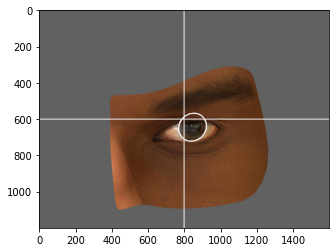

In [18]:
def visualize_image(image_id):   
    %matplotlib inline
    im = Image.open(DATA_PATH + f'{image_id}.jpg')
    
    with open(DATA_PATH + f'{image_id}.json', 'r') as infile:
        draw = ImageDraw.Draw(im)
        data = json.load(infile)
        x_0, y_0, _ = data["iris_2d"][0][1:-1].split(',')
        x_1, y_1 = (x_0, y_0)
        
        for koord in data["iris_2d"]:
            x_2, y_2, _ = koord[1:-1].split(',')

            draw.line((float(x_1), INPUT_DIM['y']-float(y_1), 
                       float(x_2), INPUT_DIM['y']-float(y_2)), width=7)
            
            x_1, y_1 = float(x_2), float(y_2)
        
        draw.line((float(x_2), INPUT_DIM['y']-float(y_2), 
                   float(x_0), INPUT_DIM['y']-float(y_0)), width=7)
        draw.line((INPUT_DIM['x']/2, 0, 
                   INPUT_DIM['x']/2, INPUT_DIM['y']), width=5)
        draw.line((0, INPUT_DIM['y']/2, 
                   INPUT_DIM['x'], INPUT_DIM['y']/2), width=5)
        
        imshow(np.asarray(im))
#visualize_image(np.random.randint(1, 50))
visualize_image(50)

### Random Cropping
Crops the image to the target dims. For the example size of 1600x1200 a cropping to 320x320 is ideal since it fits every eye somewhat tightly. For input sizes some more empirical data is needed. 
The `FACTOR` value ensures that the eyes aren't centered on all images by moving the cropping-windows to the the sides. With a value of `10` the eye might shift up to 320/10 = 32px to each side. 
Lower values might lead to a cropping of the iris and pupil. 

In [19]:
def get_offset():
    FACTOR = 10
    rand_x = random.randint(-TARGET_DIM['x'], TARGET_DIM['x'])/ FACTOR
    rand_y = random.randint(-TARGET_DIM['y'], TARGET_DIM['y'])/ FACTOR
    
    x_offset = (INPUT_DIM['x'] - TARGET_DIM['x'])/2 + rand_x 
    y_offset = (INPUT_DIM['y'] - TARGET_DIM['y'])/2 + rand_y
    
    return x_offset, y_offset, rand_x, rand_y

In [20]:
def crop_image(name, x_off, y_off):    
    im = Image.open(f'{DATA_PATH}{name}.jpg')
    upper = y_off
    left  = x_off
    lower = y_off + TARGET_DIM['y']
    right = x_off + TARGET_DIM['x']
    #print(f'left {left}, upper {upper}, right {right}, lower {lower}')
    im = im.crop((left, upper, right, lower))
    im.save(f'{CROP}{name}.jpg')

In [21]:
def get_bbox(data, x_off, y_off, rand_y):
    X, Y = [], []
    for koord in data['iris_2d']:
        x, y, _ = koord[1:-1].split(',')
        X.append(float(x) - x_off)
        Y.append(float(y) - y_off + 2*rand_y)
    #print(f"X: min {min(X)}, max {max(X)}, Y: min {min(Y)}, max {max(Y)})")
    return min(X), max(X), min(Y), max(Y)

### Annotations
The annotations for the Yolov5 dataset-pipline are defined as follows for each picture:
* **center x/y:** The center of the object 
* **width/height:** The width from the center to the outer BoundingBox of an object

All of these values are normalized between [0, 1]. 
Hint: The center of the Y-Axis is inverted, since the origin is in the top left

In [22]:
def prepare_annotation(label, center_x, center_y, width, height):
    if label == 'pupil': 
        label = 0
    if label == 'iris': 
        label = 1
    return f'{label} {center_x} {center_y} {width} {height}\n'

In [23]:
def absolute_to_relative(x_min, x_max, y_min, y_max):
    center_x =   (x_max + x_min) / 2 / TARGET_DIM['x']
    center_y = 1-(y_max + y_min) / 2 / TARGET_DIM['y']

    width    =   (x_max - x_min) / TARGET_DIM['x']
    height   =   (y_max - y_min) / TARGET_DIM['y']

    return center_x, center_y, width, height

### Details 
The details might be used for different examinations of the quality of the dataset. Especially in a recent time social topics have gathered attention in the machine learning world. Additionally in medicine it is important to gurantee each and every patient the best possible treatment. 

This data is not included in the annotations, but in a seperate CSV document.

In [24]:
def get_details(data):
    skin = data["eye_region_details"]["primary_skin_texture"]
    iris_color = data["eye_details"]["iris_texture"]
    pupil_size = data["eye_details"]["pupil_size"]
    iris_size = data["eye_details"]["iris_size"]
    
    return skin, iris_color, pupil_size, iris_size

In [25]:
def prepare_iris_data(crop=False):
    X_min, X_max, Y_min, Y_max, CX, CY, DX, DY = [], [], [], [], [], [], [], []
    Skin, Iris_color, Pupil_size, Iris_size, File = [], [], [], [], []

    files = os.listdir(DATA_PATH)
    for index, file in enumerate(files):
        name, ext = os.path.splitext(file)
        if ext == '.json':
            with open(DATA_PATH + file, 'r') as infile:
                data = json.load(infile)

                x_off, y_off, rand_x, rand_y = get_offset()
                if crop:
                    crop_image(name, x_off, y_off)       

                for absolute, el in zip((X_min, X_max, Y_min, Y_max), get_bbox(data, x_off, y_off, rand_y)): 
                    absolute.append(np.round(el, 2))

                for relativ, el in zip((CX, CY, DX, DY), absolute_to_relative(*get_bbox(data, x_off, y_off, rand_y))): 
                    relativ.append(np.round(el, 4))                

                for details, el in zip((Skin, Iris_color, Pupil_size, Iris_size), get_details(data)): 
                    details.append(el)

                File.append(f'{name}.jpg')


    d = {'file': File, 
         'iris_xmin': X_min, 'iris_xmax': X_max, 'iris_ymin': Y_min, 'iris_ymax': Y_max, 
         'iris_width': DX, 'iris_height': DY, 'iris_center_x': CX, 'iris_center_y': CY, 
         'pupil_size': Pupil_size, 'iris_size': Iris_size, 'skin': Skin, 'iris_color': Iris_color}

    df = pd.DataFrame(data=d)
    df.to_csv(f'{TEMP_PATH}dataset_crop.csv')

In [26]:
if False:
    prepare_iris_data(crop=True)

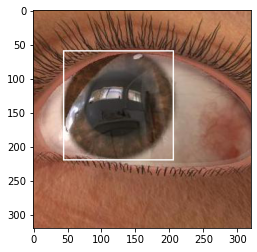

In [27]:
def draw_bbox(image_id, path, xmin, xmax, ymin, ymax):
    %matplotlib inline
    im = Image.open(f'{path}{image_id}')
    draw = ImageDraw.Draw(im)

    draw.rectangle((xmin, 320-ymin, xmax, 320-ymax), width=2)
    draw.line((INPUT_DIM['x']/2, 0, INPUT_DIM['x']/2, INPUT_DIM['y']), width=2)
    
    
    draw.line((INPUT_DIM['x']/2, 0, INPUT_DIM['x']/2, INPUT_DIM['y']), width=1)
    draw.line((0, INPUT_DIM['y']/2, INPUT_DIM['x'], INPUT_DIM['y']/2), width=1)
        
    imshow(np.asarray(im))

df = pd.read_csv(f'{TEMP_PATH}dataset_crop.csv')
row = df.iloc[0]
draw_bbox(row['file'], CROP, row['iris_xmin'], row['iris_xmax'], row['iris_ymin'], row['iris_ymax'])

# Semi Supervised Pupil Labeling
For the next step we need to generate the annotations for the pupils. We use an ensemble of five Yolov5 networks that were trained on a pre-existing dataset that focuses sololy on pupils. 
The goal of this is to reduce the error in the BoundingBoxes which each single network predicts. 
Teh training of the networks takes about 1h each and the full labeling takes approx. 1h to complete on a RTX 2070. One potential speedup for very large datasets might be to write all outputs to a single `.csv` instead of a new `.txt` for every inference.  

Freshly generated annotations and weights have to be moved by hand to fit the format. These files can be found in `yolov5/yolov5/runs` and then either `train` or `detect` (depending on the task) and the most recent experiements, indicated by the highest numer in the experiment number.  

_Hint:_ If for some reason a folder here doesn't exist, this notebook throws `no such file: {detect}`

In [28]:
def train_first_network():
    train = f'{CURRENT_DIR}/yolov5/yolov5/train.py'
    output = f'--project {CURRENT_DIR}/labeling_models/first'
    settings = f'--img 320 --epochs 20 --weights yolov5x.pt'
    data = f'--data /home/daniel/Seafile/Masterarbeit/pupil-detection/yolov5/pupil/pupil.yaml'

    !python {train} {data} {settings} {output} --batch 14
    !python {train} {data} {settings} {output} --batch 15 
    !python {train} {data} {settings} {output} --batch 16 
    !python {train} {data} {settings} {output} --batch 17 
    !python {train} {data} {settings} {output} --batch 18 

In [29]:
def create_first_pupil_annotations():
    detect = f'{CURRENT_DIR}/yolov5/yolov5/detect.py'    
    weights = [f'--weights {CURRENT_DIR}/labeling_models/first/exp/weights/best.pt',
              f'--weights {CURRENT_DIR}/labeling_models/first/exp2/weights/best.pt',
              f'--weights {CURRENT_DIR}/labeling_models/first/exp3/weights/best.pt',
              f'--weights {CURRENT_DIR}/labeling_models/first/exp4/weights/best.pt',
              f'--weights {CURRENT_DIR}/labeling_models/first/exp5/weights/best.pt']
    output = f'--project {FIRST}/detection'
    settings = f'--conf 0.7 --img 320  --save-txt --nosave --max-det 1 {output}'
    
    for weight in weights:    
        !python {detect} {weight} --source {CROP} {settings}     

In [31]:
def get_raw_annotations(paths, name):        
    file = f'{name}.txt'
    CX, CY, DX, DY = [], [], [], []
    for path in paths:
        if os.path.exists(path+file):
            with open(path+file, 'r') as infile:
                # the first return value of file.split is the label which we want to ignore here
                
                for lis, el in zip((CX, CY, DX, DY), tuple(infile.readline().split( )[1:])): 
                    lis.append(float(el))  
    return CX, CY, DX, DY    

In [32]:
if False:
    train_first_network()

In [33]:
if False:
    create_first_pupil_annotations()

### Prepare the training data for the annotation model


If at least 2 models found a pupil with a confidence > 0.7, move the cropped image and the corresponding labels to the new train set.

In [30]:
def calc_metric(center_x, center_y, width, height, metric=np.mean):
    center_x = np.round(metric(center_x), 4)
    center_y = np.round(metric(center_y), 4)
    width =    np.round(metric(width), 4)
    height =   np.round(metric(height), 4)
    
    return center_x, center_y, width, height

In [34]:
def prepare_next_training():
    EXP_1 = [f'{FIRST}detection/{x}/labels/' for x in os.listdir(f'{FIRST}detection/')]

    files = os.listdir(CROP)

    for index, file in enumerate(files):
        name, ext = os.path.splitext(file)     

        CX, CY, DX, DY = get_raw_annotations(EXP_1, name)      
        mean_cx, mean_cy, mean_dx, mean_dy = calc_metric(CX, CY, DX, DY, np.mean)
        std_cx, std_cy, std_dx, std_dy     = calc_metric(CX, CY, DX, DY, np.std)

        if len(CX) > 1 and std_cx < 0.01 and std_cy < 0.01 and std_dx < 0.01 and std_dy < 0.01:
            annotation = prepare_annotation('pupil', mean_cx, mean_cy, mean_dx, mean_dy)

            if np.random.rand() > TRAIN_TEST_SPLIT:
                !cp {CROP}{name}.jpg {SECOND_IMAGES_TRAIN}{name}.jpg
                with open(f'{SECOND_LABELS_TRAIN}{name}.txt', 'w') as label:
                    label.write(prepare_annotation('pupil', mean_cx, mean_cy, mean_dx, mean_dy))    
            else:
                !cp {CROP}{name}.jpg {SECOND_IMAGES_VAL}{name}.jpg
                with open(f'{SECOND_LABELS_VAL}{name}.txt', 'w') as label:
                    label.write(prepare_annotation('pupil', mean_cx, mean_cy, mean_dx, mean_dy))    

        with open(f'{SECOND}pupil.yaml', 'w') as outfile:
            p = 'temp/second/images/'
            outfile.write(f'train: {p}train/\nval: {p}val/\nnc: 1\nnames: [\'pupil\']')

In [35]:
def train_second_network():
    train = f'{CURRENT_DIR}/yolov5/yolov5/train.py'
    output = f'--project {CURRENT_DIR}/labeling_models/second'
    settings = f'--img 320 --epochs 20 --weights yolov5x.pt'
    data = f'--data {SECOND}pupil.yaml'

    !python {train} {data} {settings} {output} --batch 14
    !python {train} {data} {settings} {output} --batch 15
    !python {train} {data} {settings} {output} --batch 16
    !python {train} {data} {settings} {output} --batch 17 
    !python {train} {data} {settings} {output} --batch 18 

In [36]:
def create_second_pupil_annotations():
    detect = f'{CURRENT_DIR}/yolov5/yolov5/detect.py'
    weights = [f'--weights {CURRENT_DIR}/labeling_models/second/exp/weights/best.pt',
              f'--weights {CURRENT_DIR}/labeling_models/second/exp2/weights/best.pt',
              f'--weights {CURRENT_DIR}/labeling_models/second/exp3/weights/best.pt',
              f'--weights {CURRENT_DIR}/labeling_models/second/exp4/weights/best.pt',
              f'--weights {CURRENT_DIR}/labeling_models/second/exp5/weights/best.pt']
    output = f'--project {SECOND}/detection'
    settings = f'--conf 0.7 --img 320  --save-txt --nosave --max-det 1 {output}'
    
    for weight in weights:
        !python {detect} {weight} --source {CROP} {settings} 


conf: 0.7, 19781 labels,  19261 labels,  20548 labels,  19546 labels,  20063 labels

In [37]:
if False:
    prepare_next_training()
    train_network()

In [38]:
if False:
    create_second_pupil_annotations()

conf 0.5: 21997 labels,  21991 labels,  21999 labels,  21997 labels,  21997 labels

conf 0.7: 21983 labels,  21962 labels,  21986 labels,  21978 labels,  21985 labels


conf 0.7_2: 21958, 21891, 21935, 21892, 21976

### Translate relative coordinates to absolute ones

In [39]:
def relative_to_absolute(mean_cx, mean_cy, mean_dx, mean_dy):
    x, y = (TARGET_DIM['x'], TARGET_DIM['y'])
    x_min = np.round((mean_cx-mean_dx/2)*x, 2)
    x_max = np.round((mean_cx+mean_dx/2)*x, 2)
    y_min = np.round((mean_cy-mean_dy/2)*y, 2)
    y_max = np.round((mean_cy+mean_dy/2)*y, 2) 
    
    return x_min, x_max, y_min, y_max 

# Run the second inference
In this inference the final annotations will be created. 
We set up a number of lists to save all the information we want to include in the dataset. 


In [7]:
def export_dataset():
    EXP_2 = [f'{SECOND}detection/exp/labels/', 
             f'{SECOND}detection/exp1/labels/', 
             f'{SECOND}detection/exp2/labels/', 
             f'{SECOND}detection/exp3/labels/', 
             f'{SECOND}detection/exp4/labels/']

    #files = os.listdir(CROP)

    File, Set, Skin, Iris_color, Pupil_size, Iris_size = [], [], [], [], [], []
    PX_min, PX_max, PY_min, PY_max, PCX, PCY, PDX, PDY = [], [], [], [], [], [], [], []
    IX_min, IX_max, IY_min, IY_max, ICX, ICY, IDX, IDY = [], [], [], [], [], [], [], []


    df = pd.read_csv(f'{TEMP_PATH}dataset_crop.csv')

    for index, row in df.iterrows():

        name, _ = row['file'].split('.')
        CX, CY, DX, DY = get_raw_annotations(EXP_2, name)      

        mean_cx, mean_cy, mean_dx, mean_dy = calc_metric(CX, CY, DX, DY, np.mean)
        std_cx, std_cy, std_dx, std_dy     = calc_metric(CX, CY, DX, DY, np.std)

        if len(CX) > 1 and std_cx < 0.02 and std_cy < 0.02 and std_dx < 0.02 and std_dy < 0.02:
            pupil = prepare_annotation('pupil', mean_cx, mean_cy, mean_dx, mean_dy)
            iris = prepare_annotation('iris', row['iris_center_x'], row['iris_center_y'], 
                                              row['iris_width'], row['iris_height'])

            is_validation = np.random.rand() < TRAIN_TEST_SPLIT
            if is_validation:        
                !cp {CROP}{name}.jpg {OUT_PATH_IMAGES_VAL}{name}.jpg
                with open(f'{OUT_PATH_LABELS_VAL}{name}.txt', 'w') as label:
                    label.write(pupil)                
                    label.write(iris)     
            else:
                !cp {CROP}{name}.jpg {OUT_PATH_IMAGES_TRAIN}{name}.jpg
                with open(f'{OUT_PATH_LABELS_TRAIN}{name}.txt', 'w') as label:
                    label.write(pupil)                
                    label.write(iris)              

            px_min, px_max, py_min, py_max = relative_to_absolute(mean_cx, mean_cy, mean_dx, mean_dy)

            File.append(row['file'])
            Set.append(is_validation)
            Skin.append(row['skin'])
            Iris_color.append(row['iris_color'])
            Pupil_size.append(row['pupil_size'])
            Iris_size.append(row['iris_size'])
            PX_min.append(px_min)
            PX_max.append(px_max)
            PY_min.append(py_min)
            PY_max.append(py_max)
            PCX.append(mean_cx)
            PCY.append(mean_cy)
            PDX.append(mean_dx)
            PDY.append(mean_dy)
            IX_min.append(row['iris_xmin'])
            IX_max.append(row['iris_xmax'])
            IY_min.append(row['iris_ymin'])
            IY_max.append(row['iris_ymax'])
            ICX.append(row['iris_center_x'])
            ICY.append(row['iris_center_y'])
            IDX.append(row['iris_width'])
            IDY.append(row['iris_height'])

        elif len(CX) == 1:
            print(f'No label data for {name}.jpg')

    # Create a dictionary of all information gathered in the previous step.

    d = {'file': File, 'is_validation': Set, 
         'pupil_xmin': PX_min, 'pupil_xmax': PX_max, 'pupil_ymin': PY_min, 'pupil_ymax': PY_max, 
         'pupil_center_x': PDX, 'pupil_center_y': PDY, 'pupil_width': PCX, 'pupil_height': PCY, 
         'iris_xmin': IX_min, 'iris_xmax': IX_max, 'iris_ymin': IY_min, 'iris_ymax': IY_max, 
         'iris_center_x': IDX, 'iris_center_y': IDY, 'iris_width': ICX, 'iris_height': ICY, 
         'pupil_size': Pupil_size, 'iris_size': Iris_size, 'skin_tone': Skin, 'iris_color': Iris_color}

    out = pd.DataFrame(data=d)
    out_val = out[out.is_validation == True]
    out_train = out[out.is_validation == False]

    # Exporting the full dataset with every information
    
    out.to_csv(f'{OUT_PATH}dataset.csv')
    out_val.to_csv(f'{OUT_PATH}dataset_val.csv')
    out_train.to_csv(f'{OUT_PATH}dataset_train.csv')
    
    
    # Dropping unnessesary information which could either be calculated from the other annotations
    # Or are not used during training
    
    drop_cols = ['is_validation', 'pupil_center_x', 'pupil_center_y', 'pupil_width', 'pupil_height', 
             'iris_center_x', 'iris_center_y', 'iris_width', 'iris_height', 'pupil_size', 'iris_size',
            'skin_tone', 'iris_color']
    out_val = out_val.drop(drop_cols, axis=1)
    out_train = out_train.drop(drop_cols, axis=1)
    out_val.to_csv(f'{OUT_PATH}dataset_val_tf.csv')
    out_train.to_csv(f'{OUT_PATH}dataset_train_tf.csv')


In [8]:
if False:
    export_dataset()

# Generate TF-Record Files

[Source which might help](https://www.dlology.com/blog/how-to-train-an-object-detection-model-easy-for-free/). The script had compatibility issues with new versions of tensorflow. 
After some bugfixing I decided to use [Roboflow](https://roboflow.com/) instead. 
The only limitation is that you are only allowed to upload datasets with a maximum size of 10.000 images. 
Otherwise it provides a GUI to add image augmentations, splits for train/test/validation data, a versioning system and other extra features like conversion between different formats to suit each and every popular machine learning framework and library. 
